In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'CAD'
share_name = 'FTS.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-03-31,1455,-679,776,154,528,865,75,1714,2097,...,0,663,744,2542,6421,12451,265,-237,276.0,2014-05-05
1,2014-06-30,1056,-403,653,63,612,628,127,1576,2074,...,0,699,721,2484,6443,12463,321,-298,276.0,2014-07-28
2,2014-09-30,1197,-406,791,32,458,782,347,3243,3652,...,0,1564,1109,4175,10886,19954,62,-340,276.0,2014-10-28
3,2014-12-31,1693,-709,984,136,230,900,321,1787,3732,...,0,330,733,2676,9911,17542,334,-850,276.0,2015-02-09
4,2015-03-31,1915,-833,1082,220,299,945,272,2068,3942,...,0,362,686,2710,10637,18843,447,-554,282.0,2015-05-05


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-03-31,2023-05-05,490.0,3319,-1312,2007,484,576,1876,569,...,1511,64630,0,361,2362,6150,26466,43363,915,-954
37,2023-06-30,2023-07-28,490.0,2594,-787,1807,346,690,1580,534,...,1492,64081,0,80,2284,5414,26808,42702,944,-982
38,2023-09-30,2023-10-28,490.0,2719,-773,1946,445,765,1648,588,...,1515,66285,0,78,2774,6368,27170,44593,940,-983
39,2023-12-31,2024-02-09,490.0,2885,899,1986,435,625,1627,566,...,1510,65920,0,119,2296,5964,27235,42588,746,-1250
40,2024-03-31,2024-04-29,491.6,3118,-1009,2109,512,569,1909,547,...,1537,67584,0,126,3116,6605,27363,43569,768,-1113


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-03-31,2023-05-05,490.0,3319,-1312,2007,484,576,1876,569,...,64630,0,361,2362,6150,26466,43363,915,-954,1.352063
37,2023-06-30,2023-07-28,490.0,2594,-787,1807,346,690,1580,534,...,64081,0,80,2284,5414,26808,42702,944,-982,1.343352
38,2023-09-30,2023-10-28,490.0,2719,-773,1946,445,765,1648,588,...,66285,0,78,2774,6368,27170,44593,940,-983,1.341033
39,2023-12-31,2024-02-09,490.0,2885,899,1986,435,625,1627,566,...,65920,0,119,2296,5964,27235,42588,746,-1250,1.361617
40,2024-03-31,2024-04-29,491.6,3118,-1009,2109,512,569,1909,547,...,67584,0,126,3116,6605,27363,43569,768,-1113,1.347550


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-03-31,2023-05-05,490.0,3319,-1312,2007,484,576,1876,569,...,64630,0,361,2362,6150,26466,43363,915,-954,1.352063
37,2023-06-30,2023-07-28,490.0,2594,-787,1807,346,690,1580,534,...,64081,0,80,2284,5414,26808,42702,944,-982,1.343352
38,2023-09-30,2023-10-28,490.0,2719,-773,1946,445,765,1648,588,...,66285,0,78,2774,6368,27170,44593,940,-983,1.341033
39,2023-12-31,2024-02-09,490.0,2885,899,1986,435,625,1627,566,...,65920,0,119,2296,5964,27235,42588,746,-1250,1.361617
40,2024-03-31,2024-04-29,491.6,3118,-1009,2109,512,569,1909,547,...,67584,0,126,3116,6605,27363,43569,768,-1113,1.347550


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-05-05,22.312338,2014-03-31,1455.0,0.0,22.242754,276.0,0.0,0.0,528.0,...,0.330231,0.669769,0.0,0.0,0.0,0.0,0.533333,0.105842,0.0,0.0
1,2014-05-12,22.168344,2014-03-31,1455.0,0.0,22.242754,276.0,0.0,0.0,528.0,...,0.330231,0.669769,0.0,0.0,0.0,0.0,0.533333,0.105842,0.0,0.0
2,2014-05-19,22.624170,2014-03-31,1455.0,0.0,22.242754,276.0,0.0,0.0,528.0,...,0.330231,0.669769,0.0,0.0,0.0,0.0,0.533333,0.105842,0.0,0.0
3,2014-05-26,22.534145,2014-03-31,1455.0,0.0,22.242754,276.0,0.0,0.0,528.0,...,0.330231,0.669769,0.0,0.0,0.0,0.0,0.533333,0.105842,0.0,0.0
4,2014-06-02,22.118635,2014-03-31,1455.0,0.0,22.242754,276.0,0.0,0.0,528.0,...,0.330231,0.669769,0.0,0.0,0.0,0.0,0.533333,0.105842,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-05-05,22.312338,2014-03-31,1455.0,0.0,22.242754,276.0,0.0,0.0,528.0,...,0.0,0.533333,0.105842,0.0,0.0,inf,1.003128,1.058111,3.106736,inf
1,2014-05-12,22.168344,2014-03-31,1455.0,0.0,22.242754,276.0,0.0,0.0,528.0,...,0.0,0.533333,0.105842,0.0,0.0,inf,0.996655,1.051282,3.099908,inf
2,2014-05-19,22.624170,2014-03-31,1455.0,0.0,22.242754,276.0,0.0,0.0,528.0,...,0.0,0.533333,0.105842,0.0,0.0,inf,1.017148,1.072899,3.121524,inf
3,2014-05-26,22.534145,2014-03-31,1455.0,0.0,22.242754,276.0,0.0,0.0,528.0,...,0.0,0.533333,0.105842,0.0,0.0,inf,1.013101,1.068630,3.117255,inf
4,2014-06-02,22.118635,2014-03-31,1455.0,0.0,22.242754,276.0,0.0,0.0,528.0,...,0.0,0.533333,0.105842,0.0,0.0,inf,0.994420,1.048925,3.097550,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

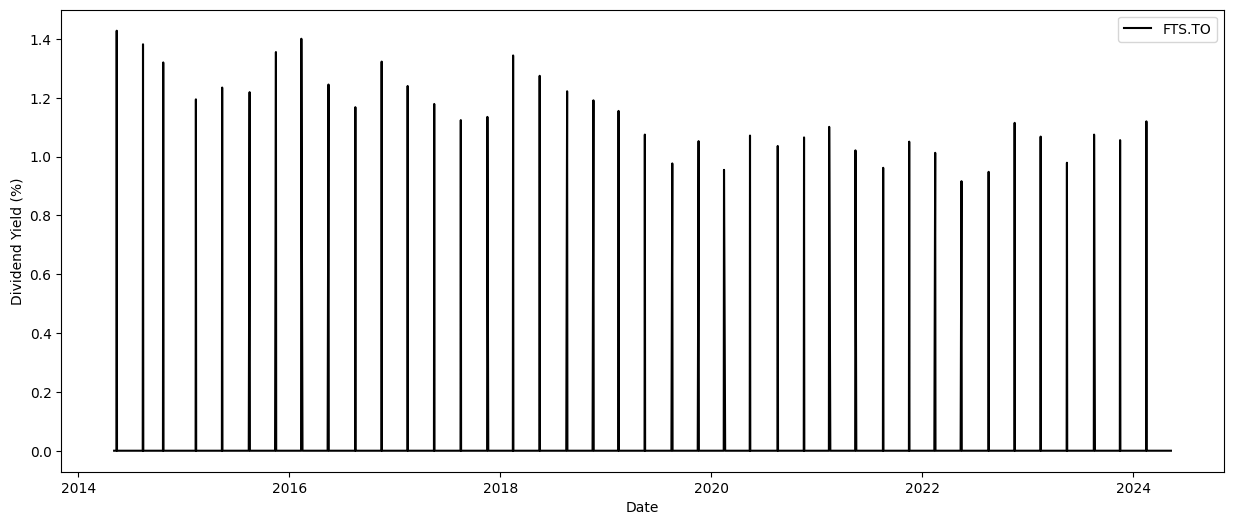

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.395209
share_price      1.000000
Name: share_price, dtype: float64


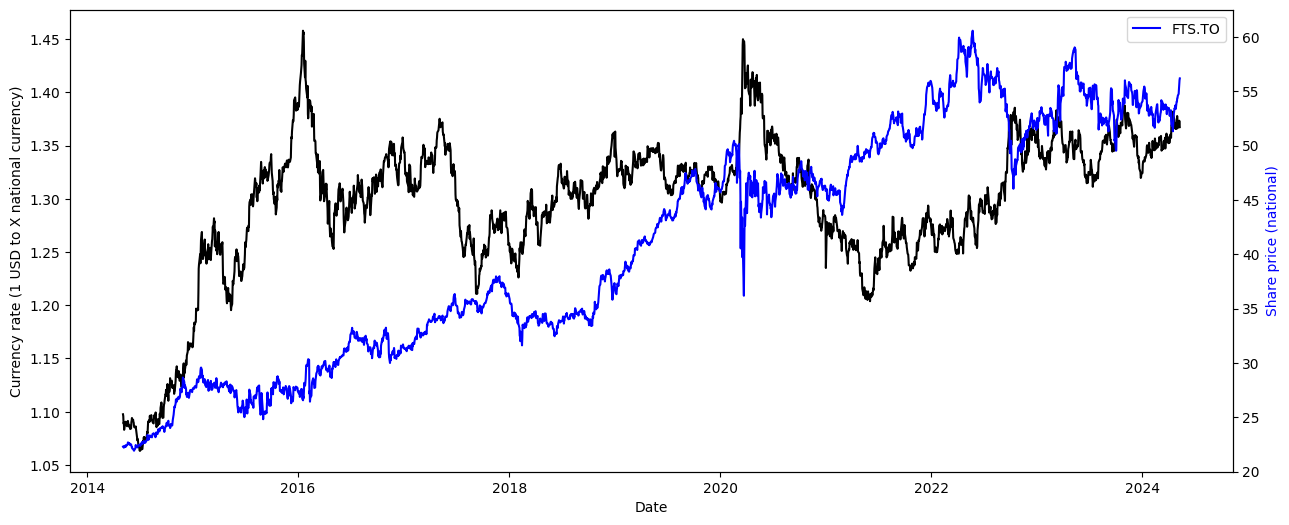

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

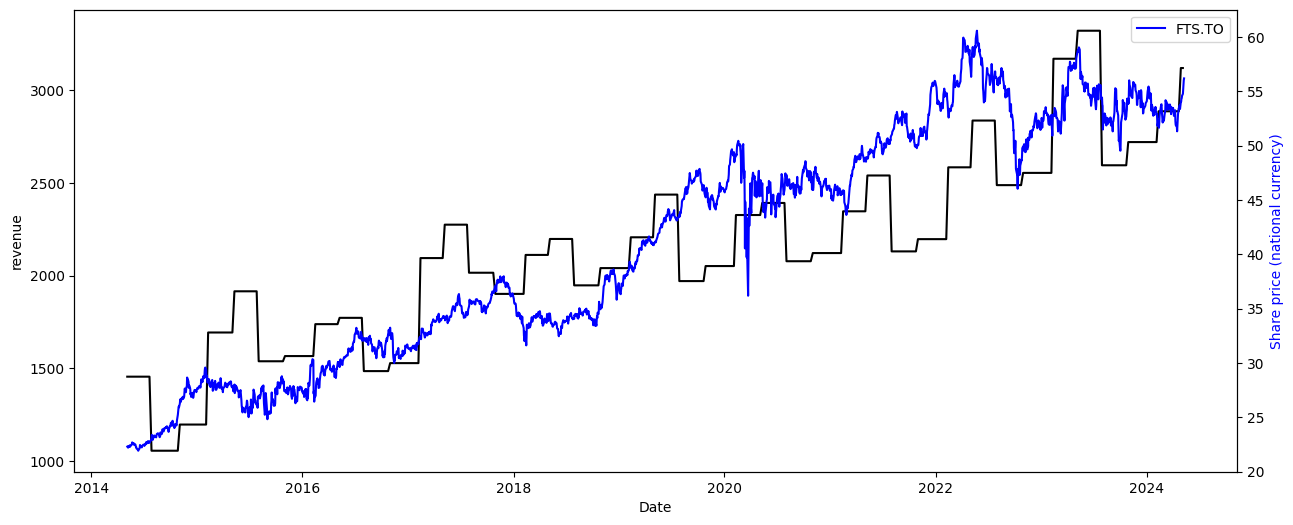

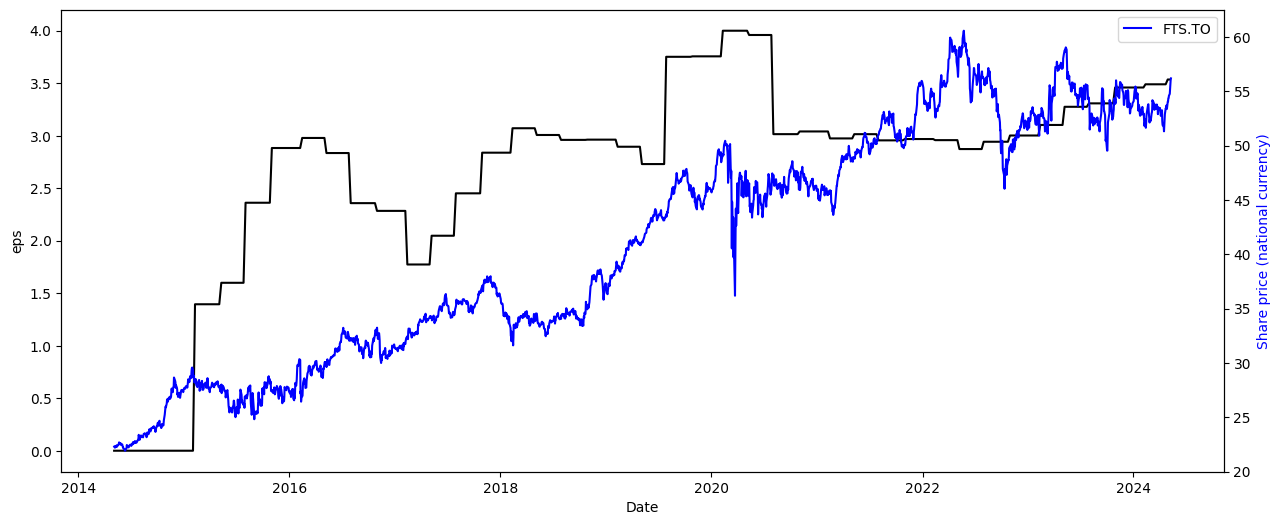

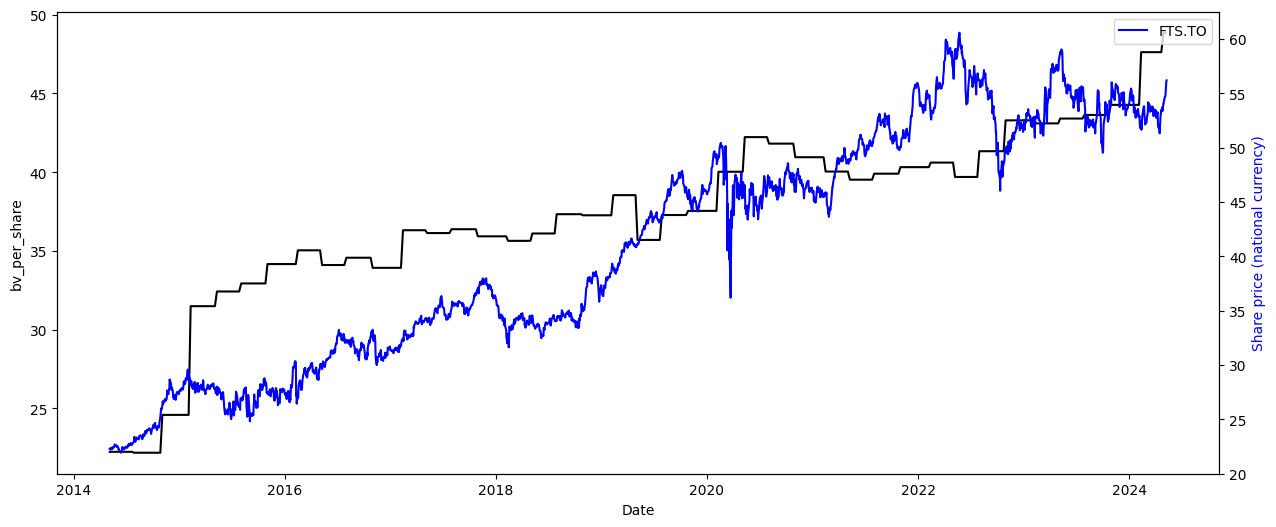

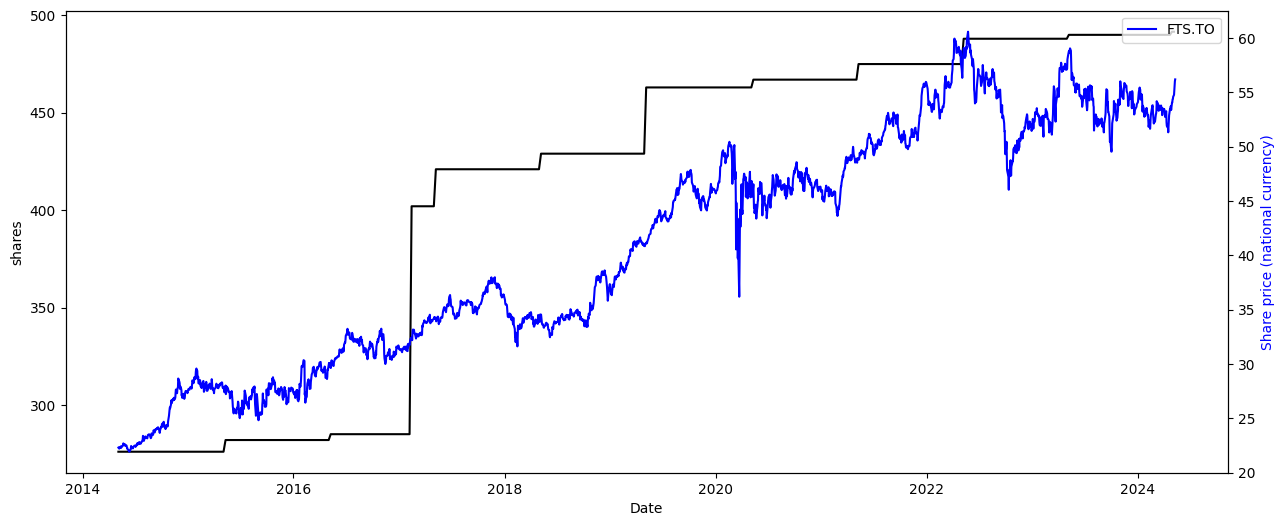

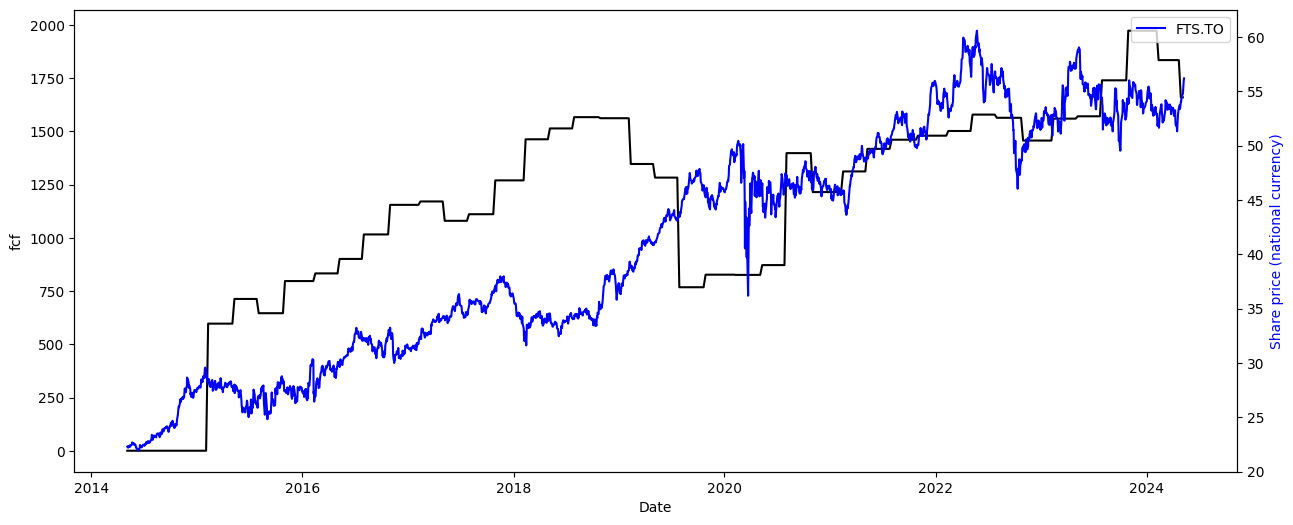

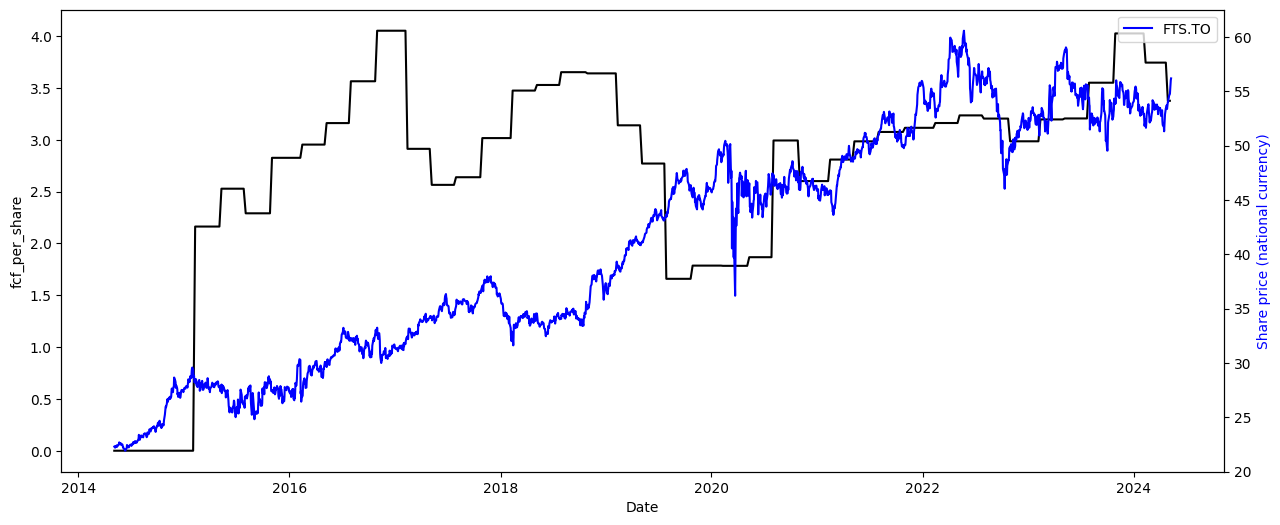

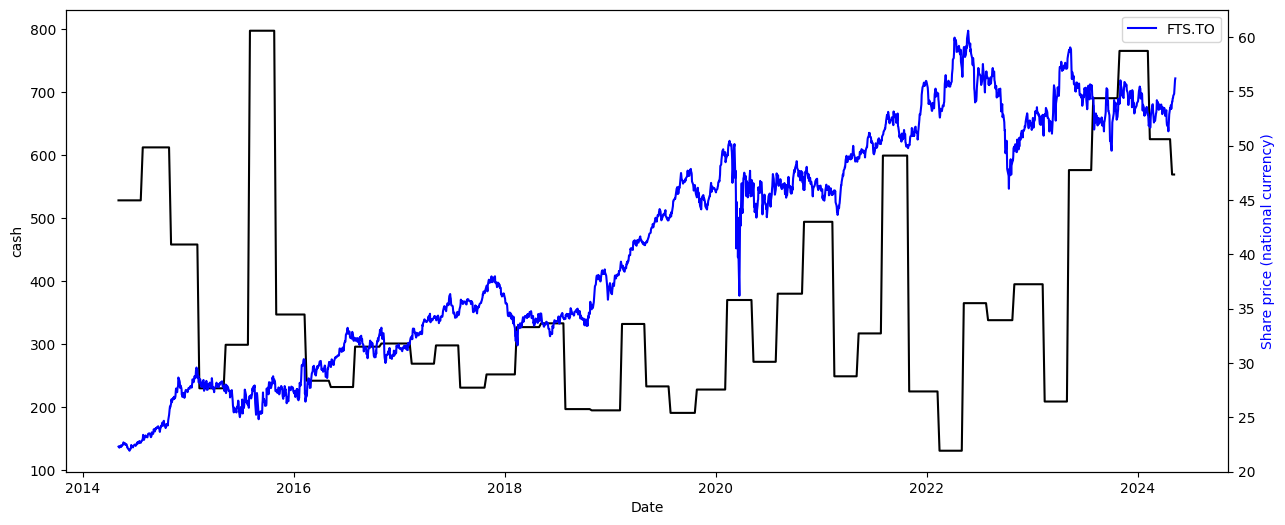

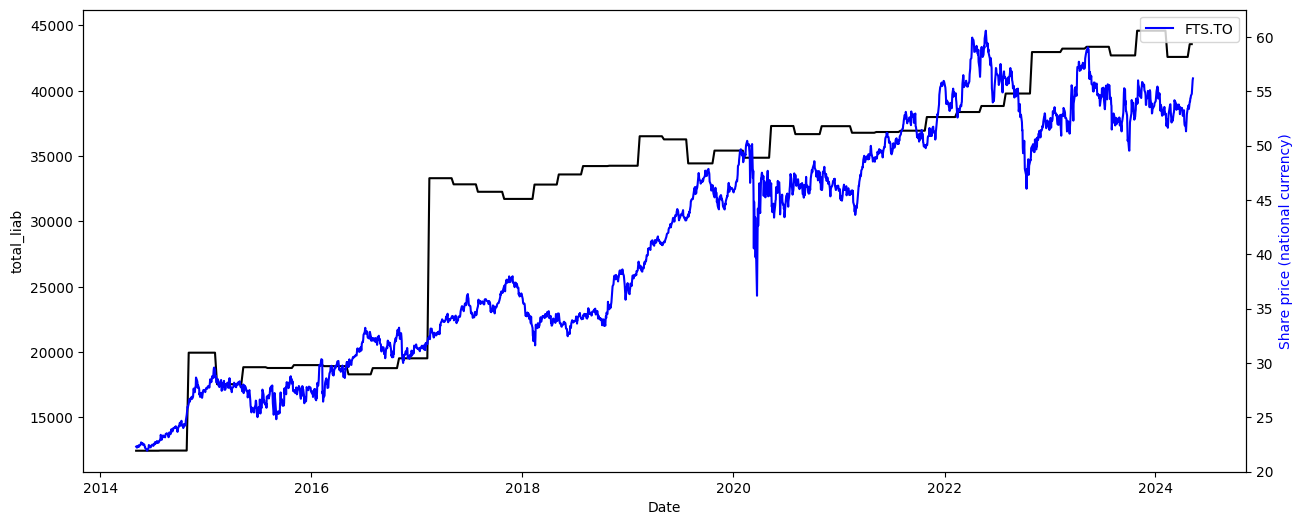

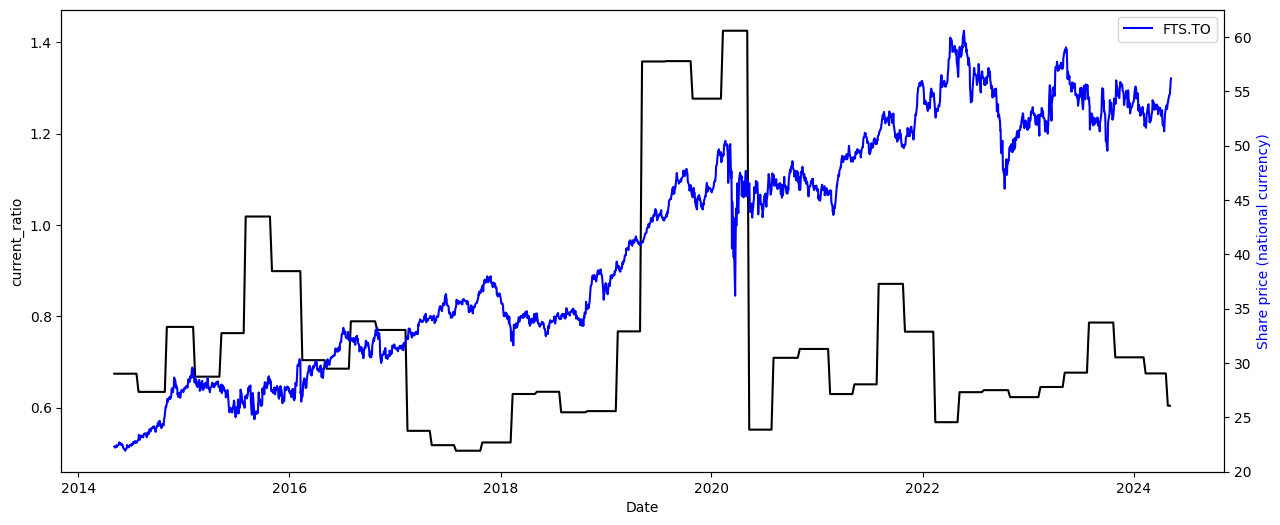

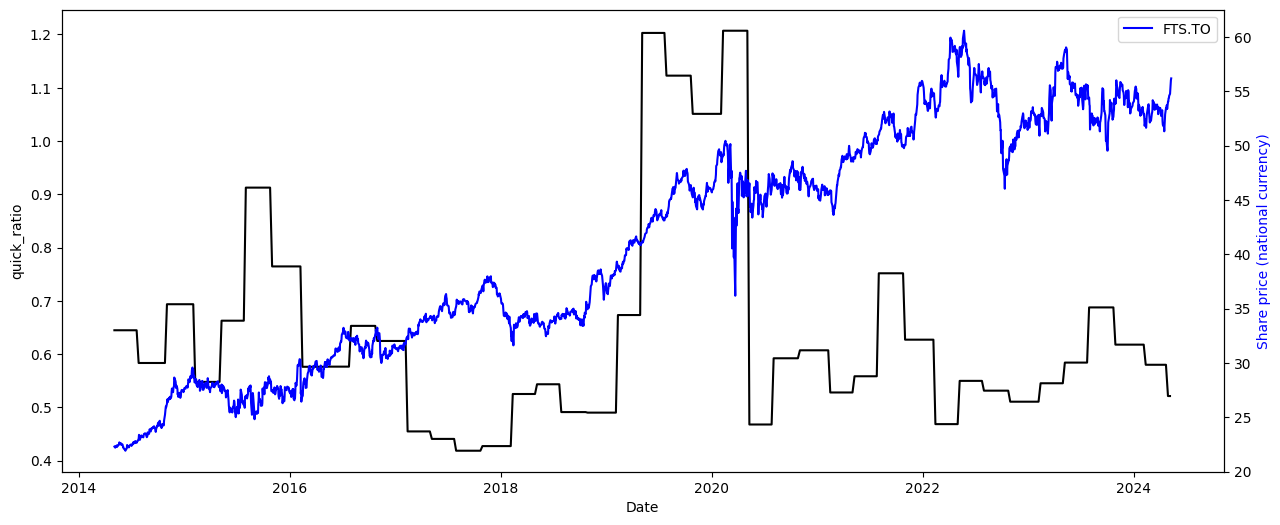

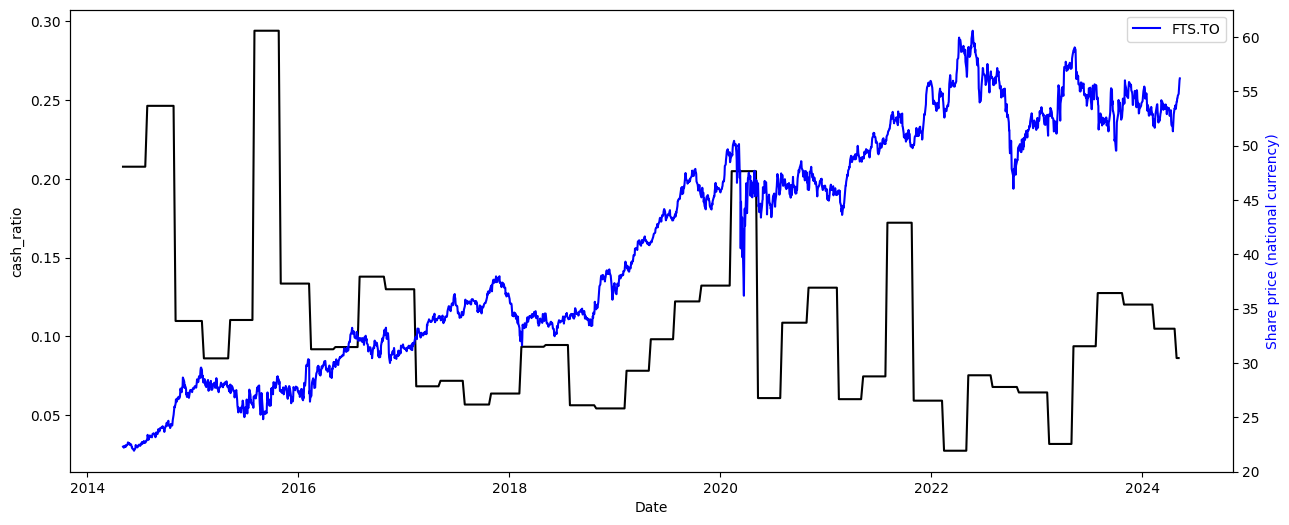

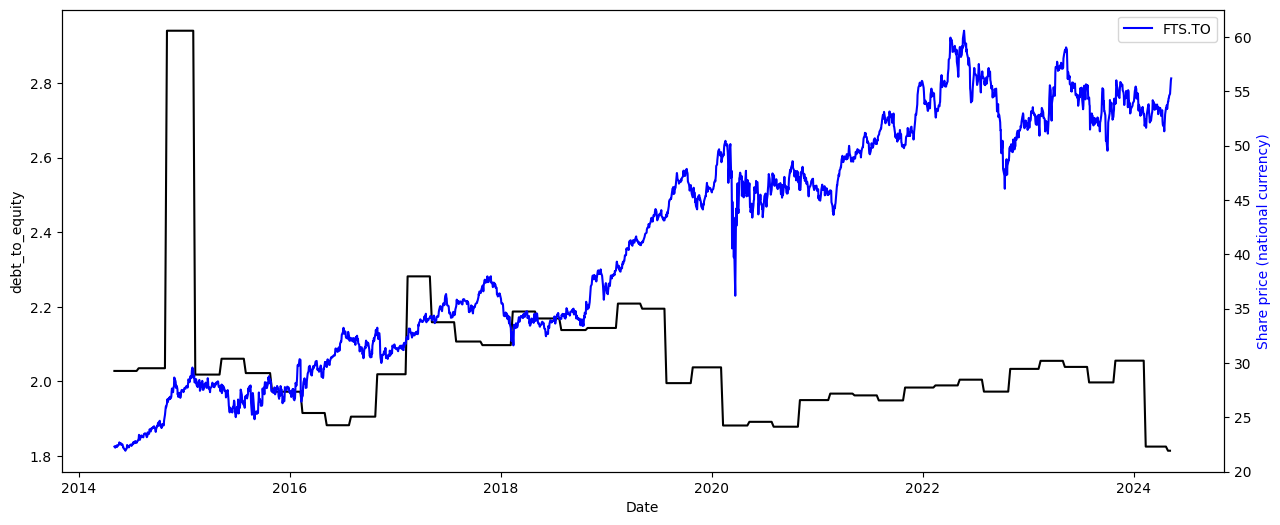

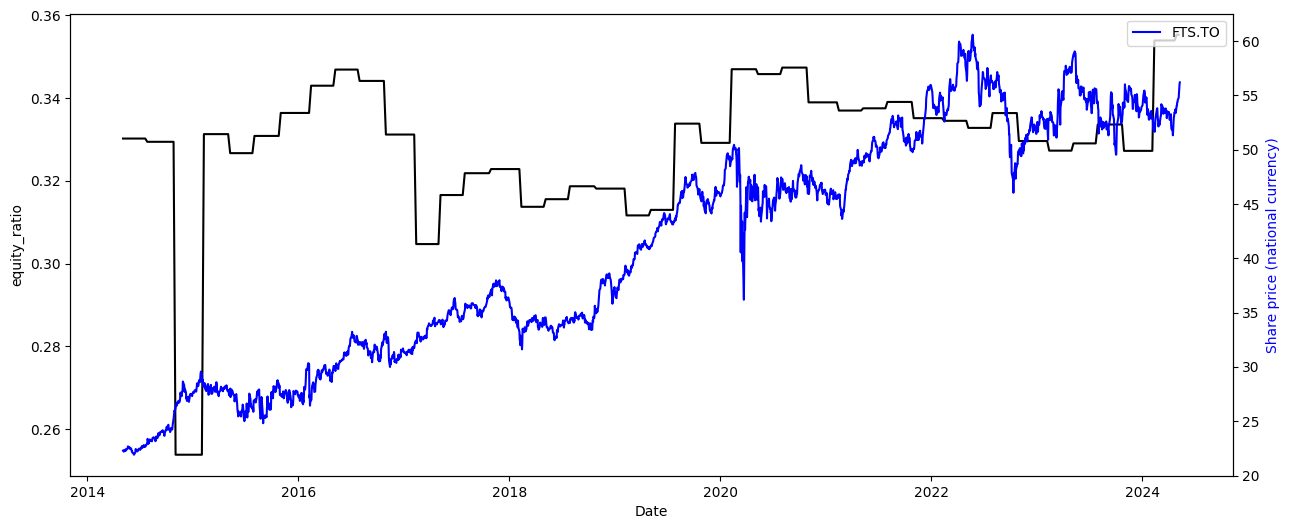

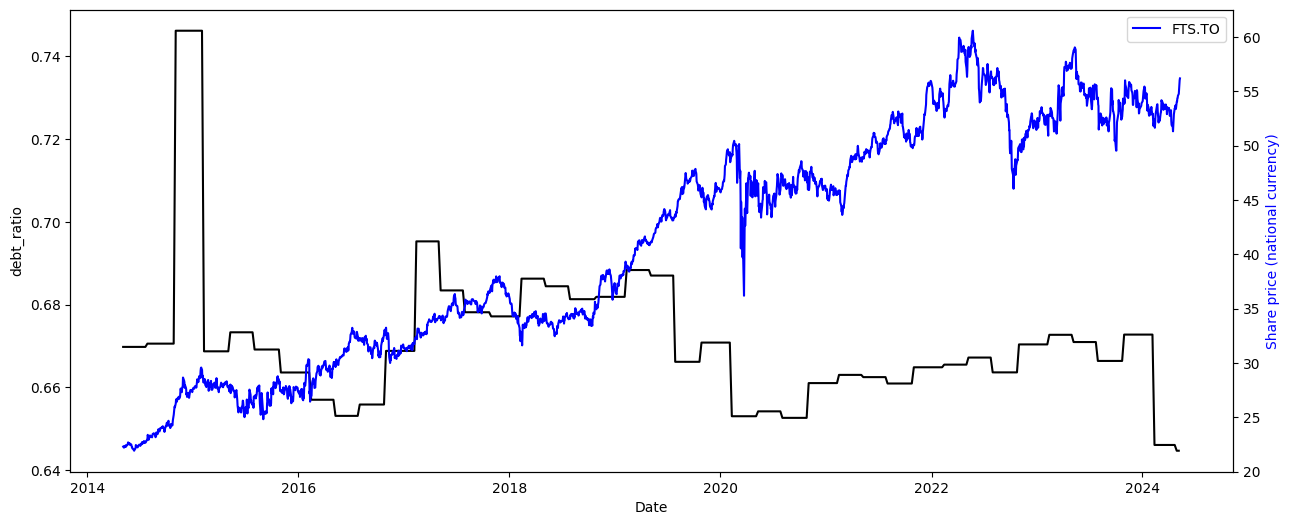

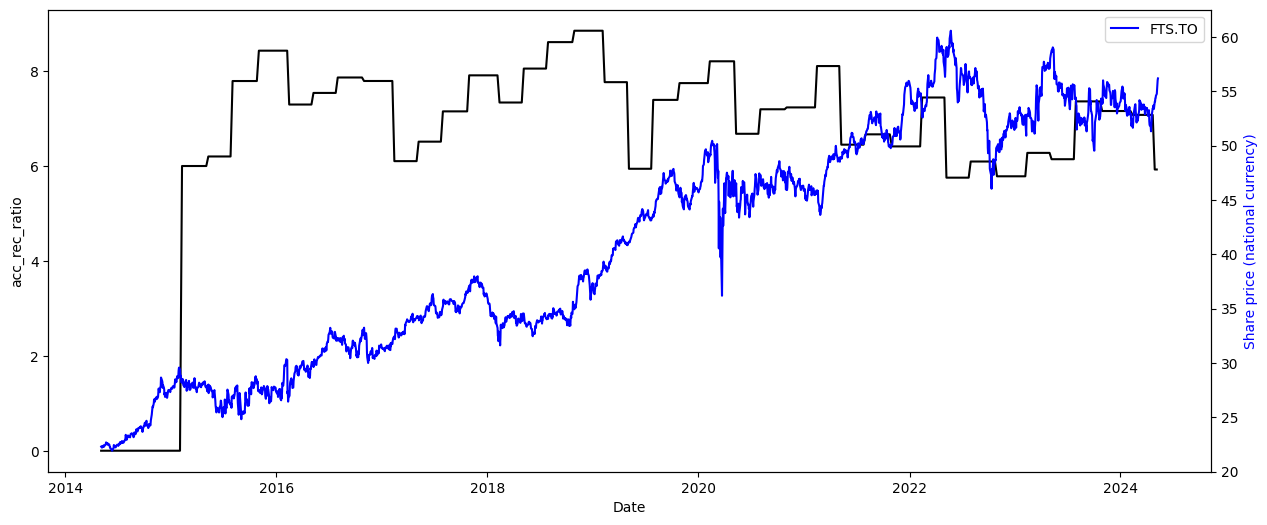

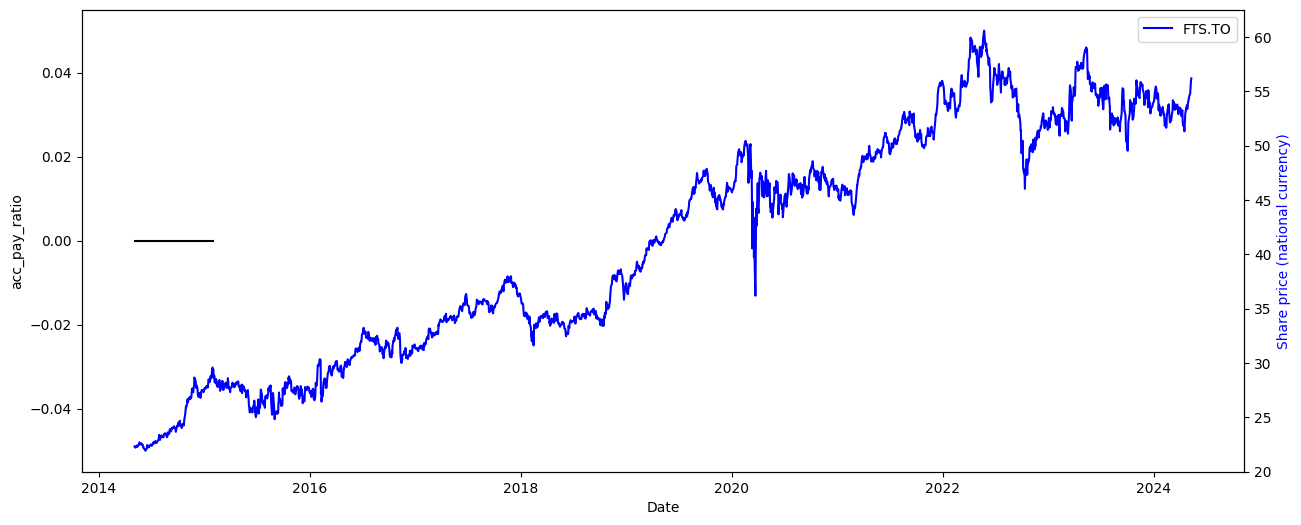

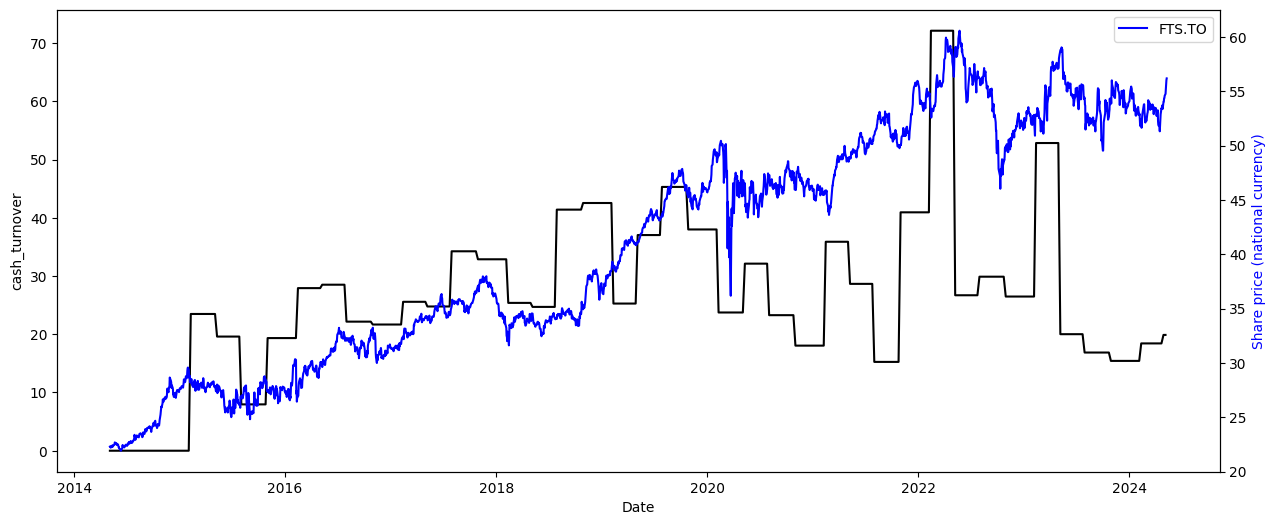

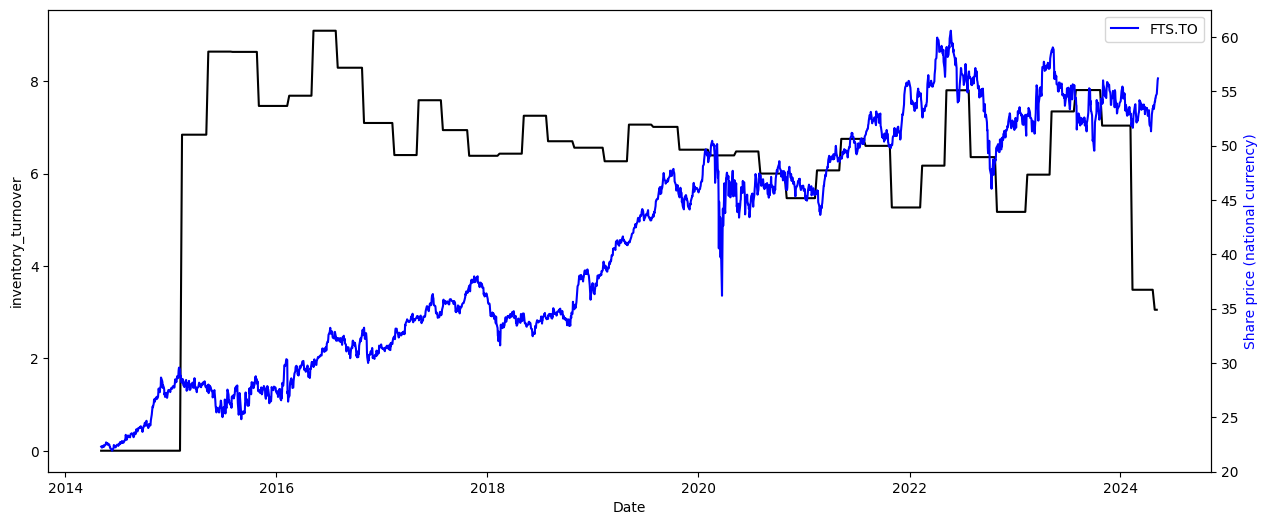

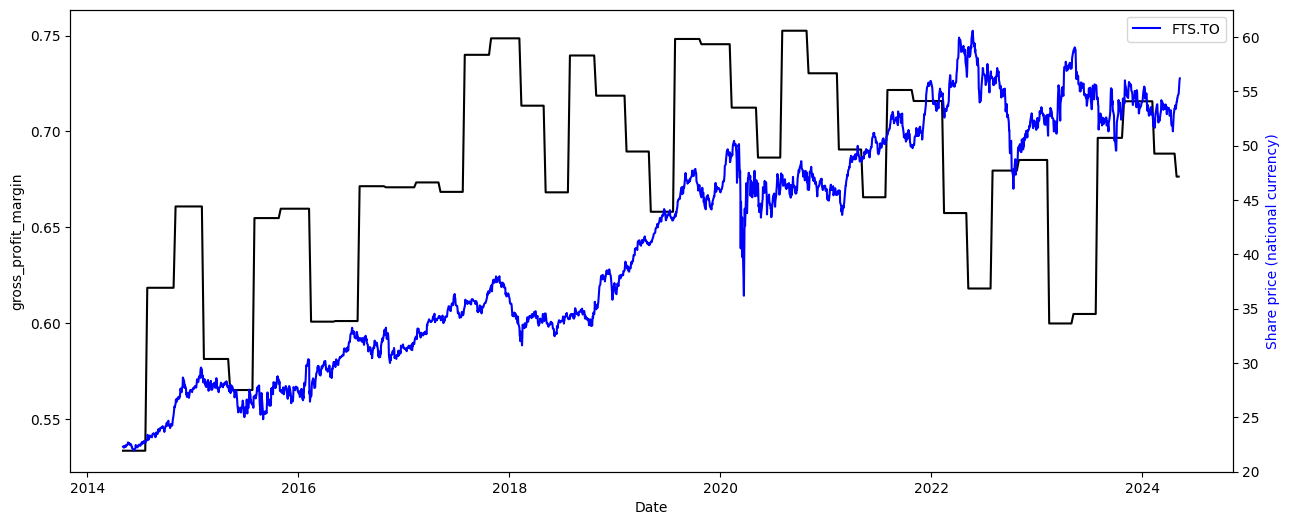

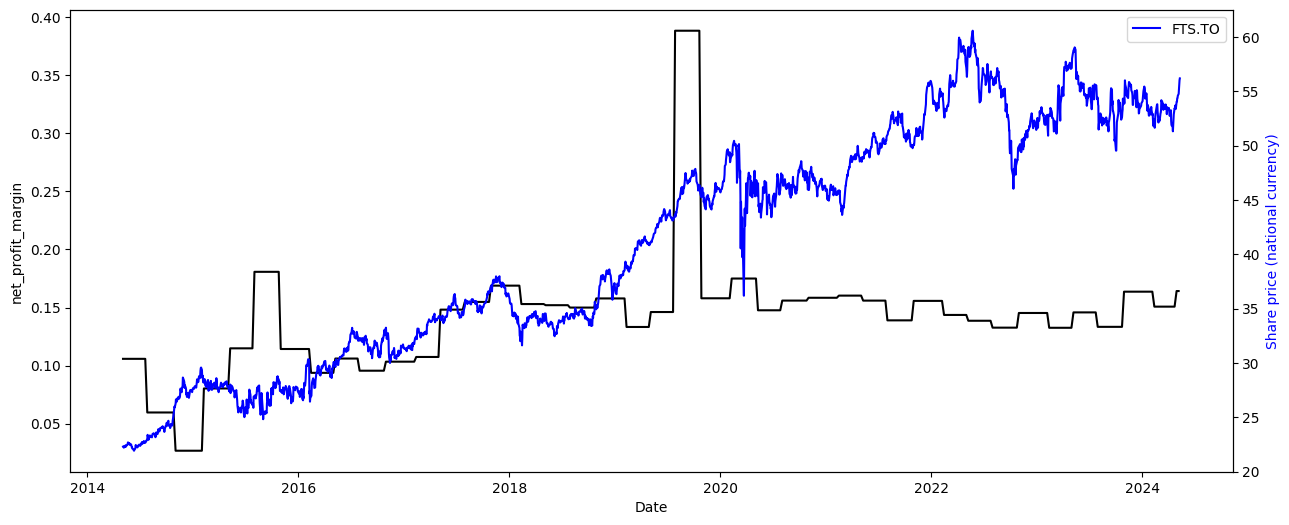

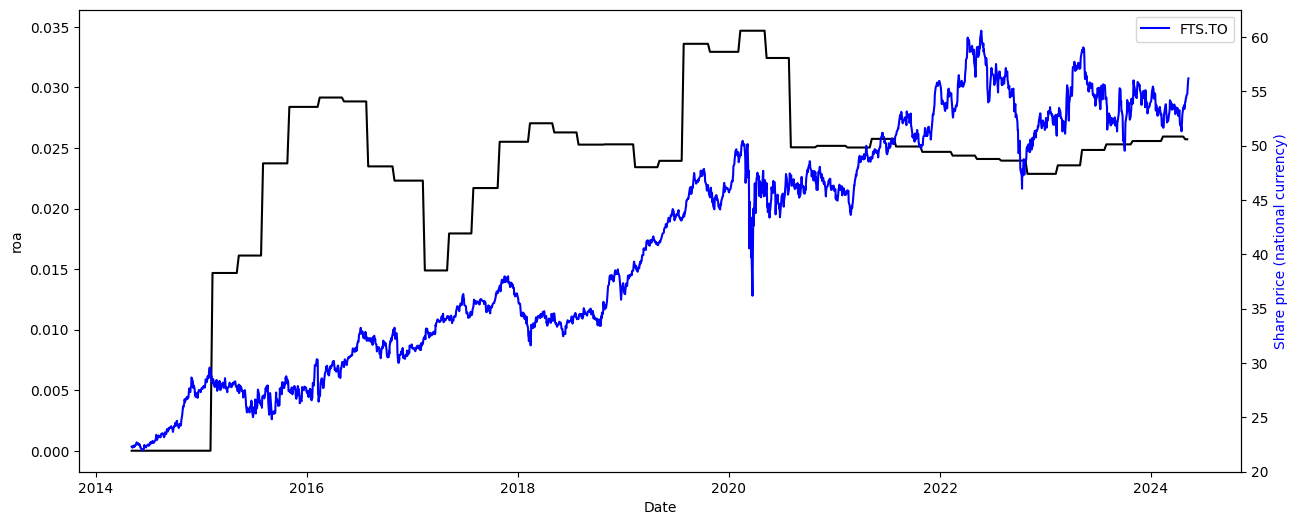

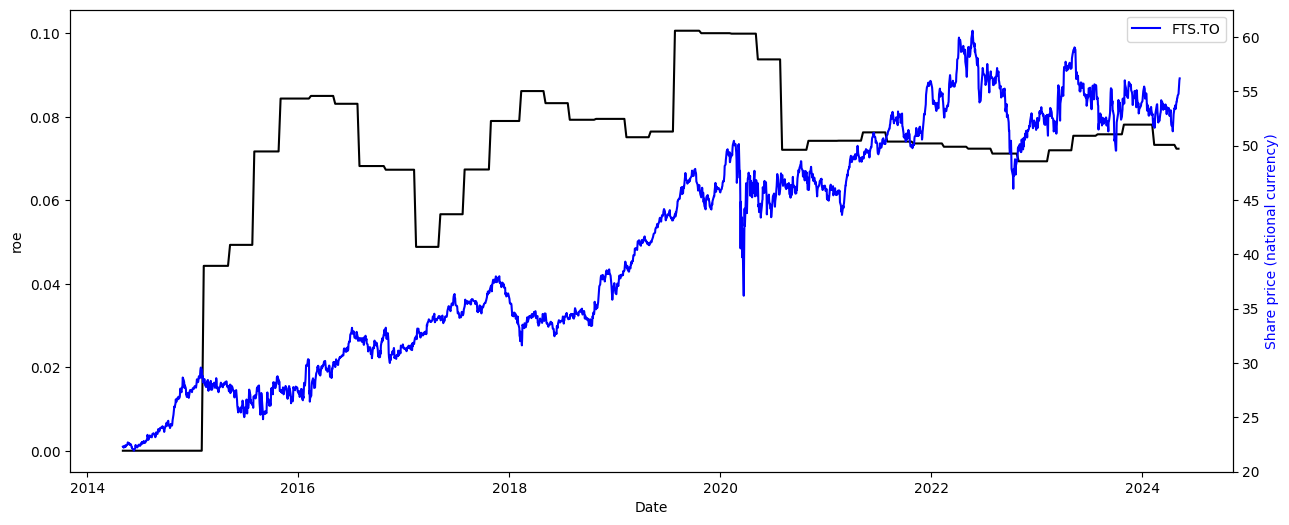

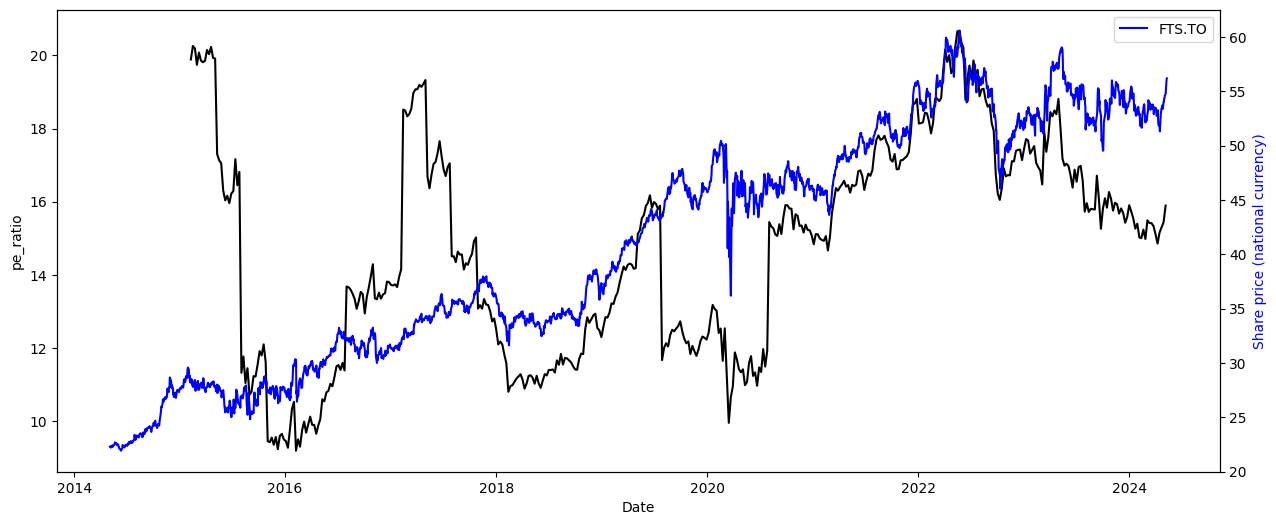

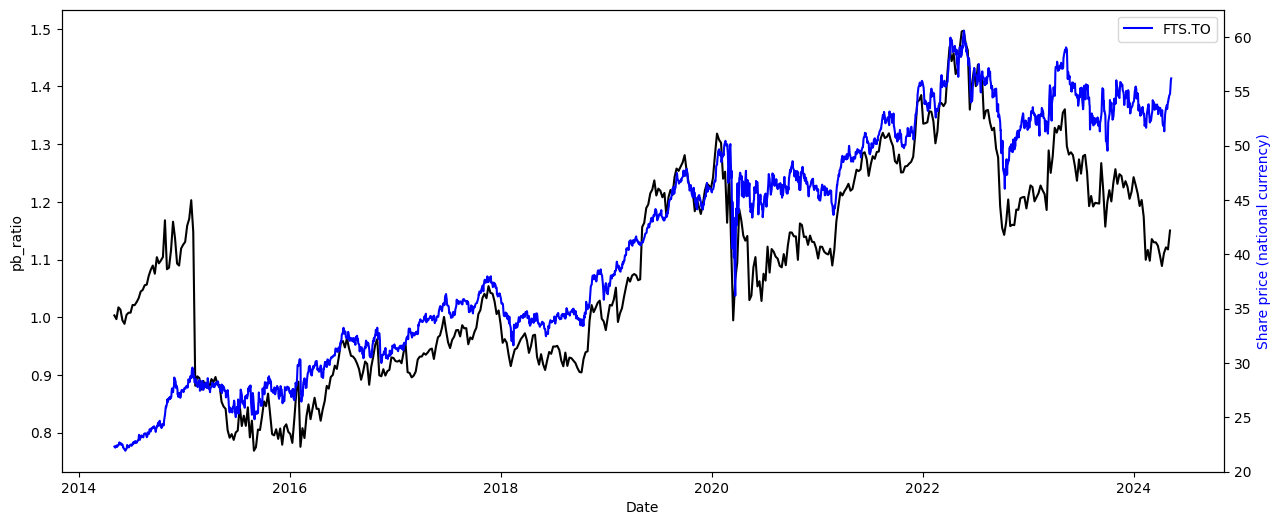

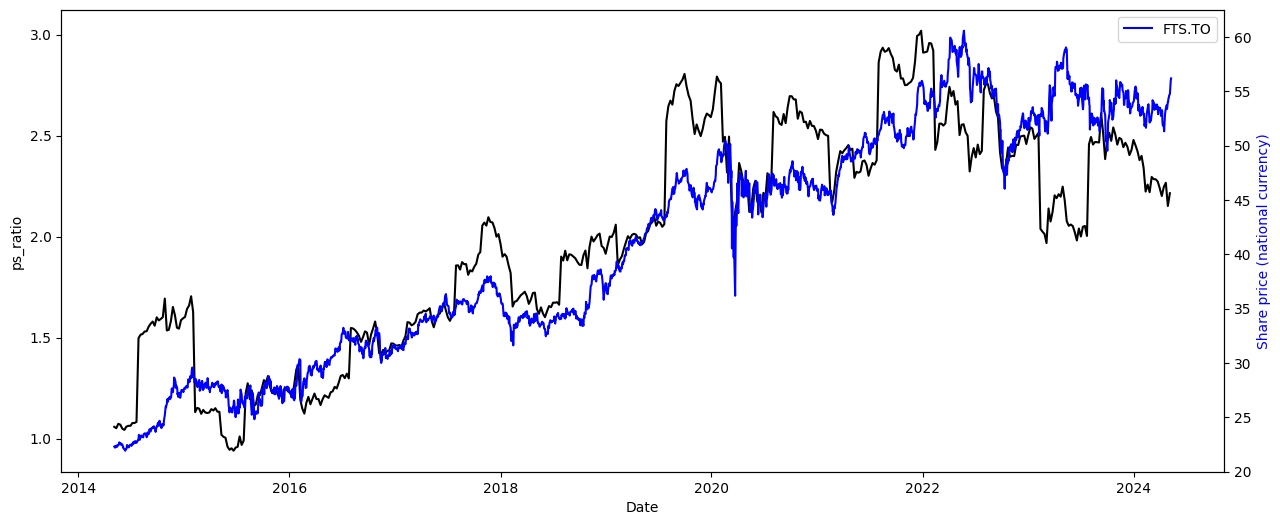

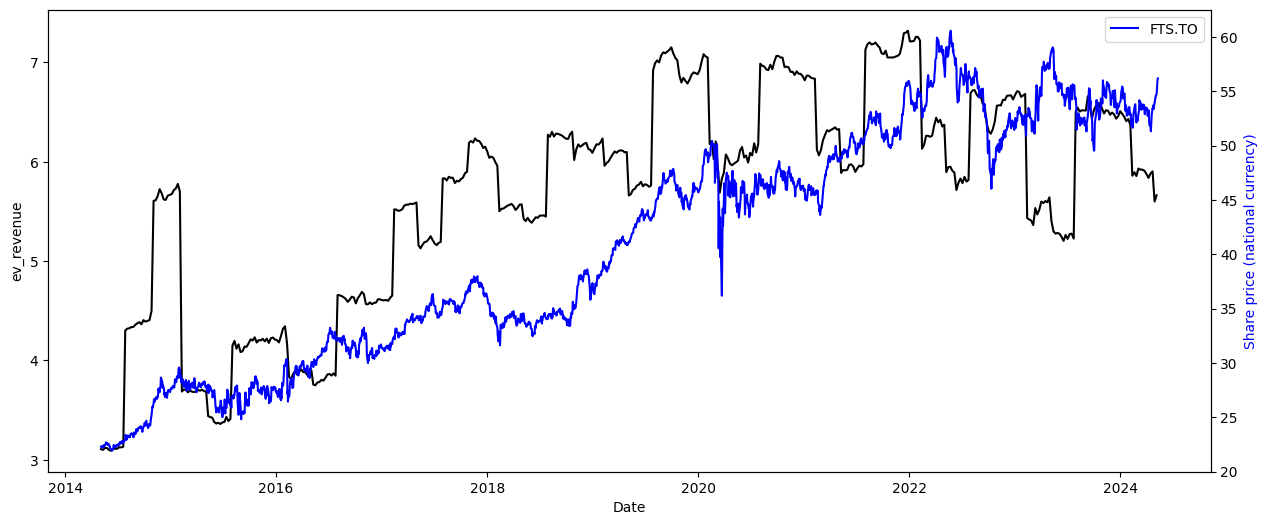

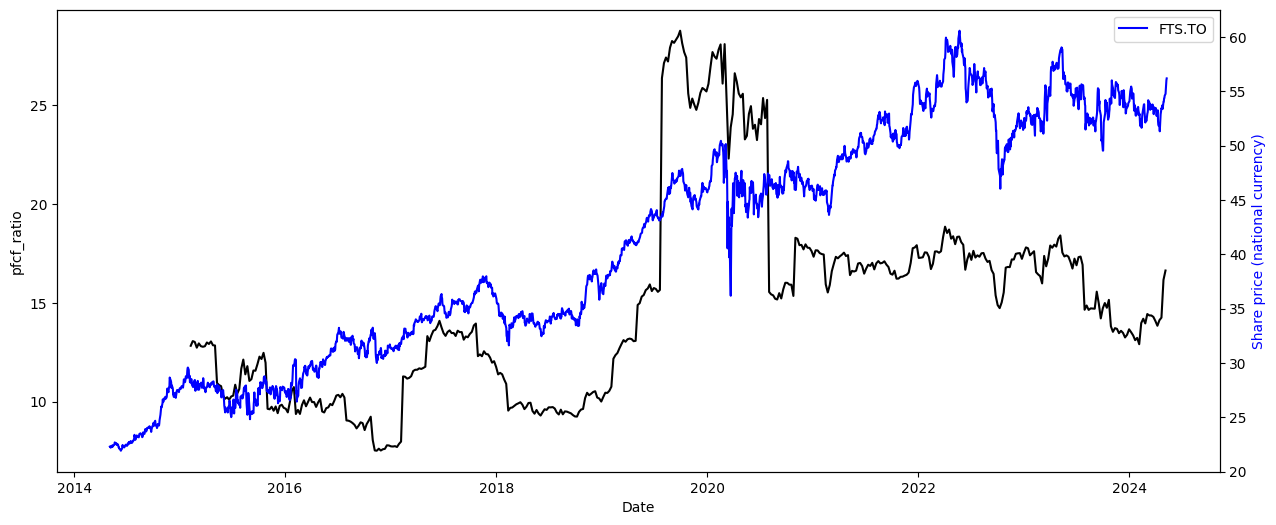

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

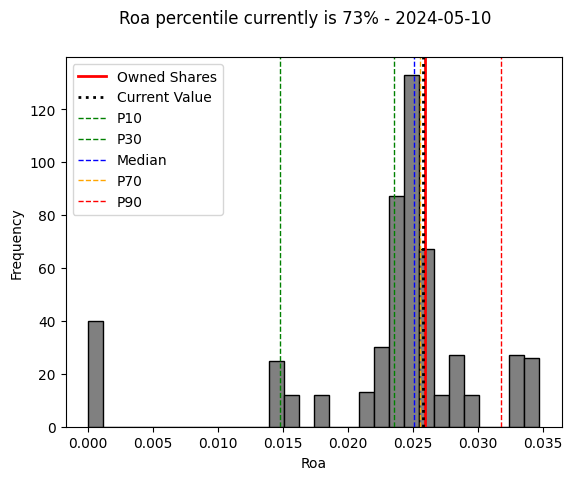

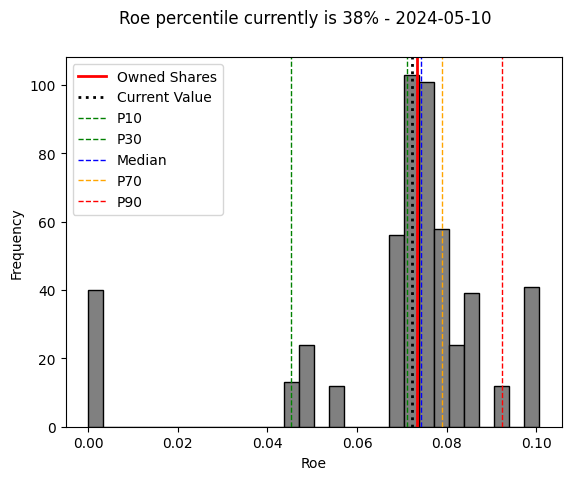

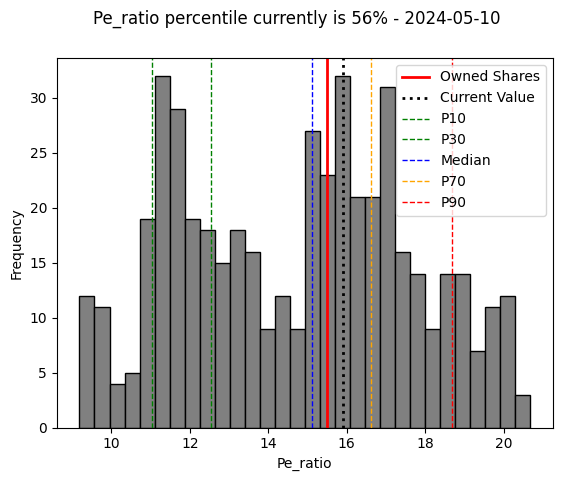

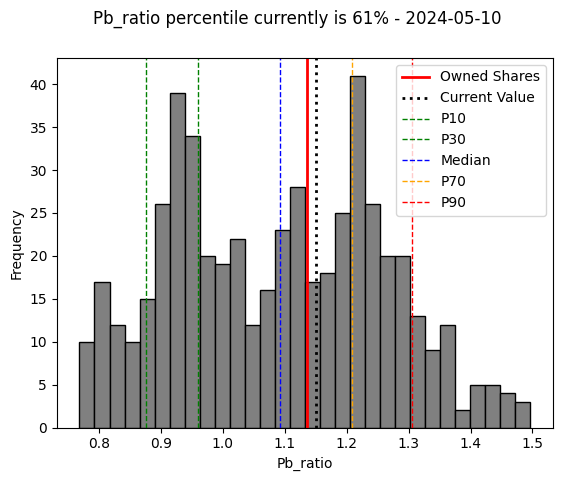

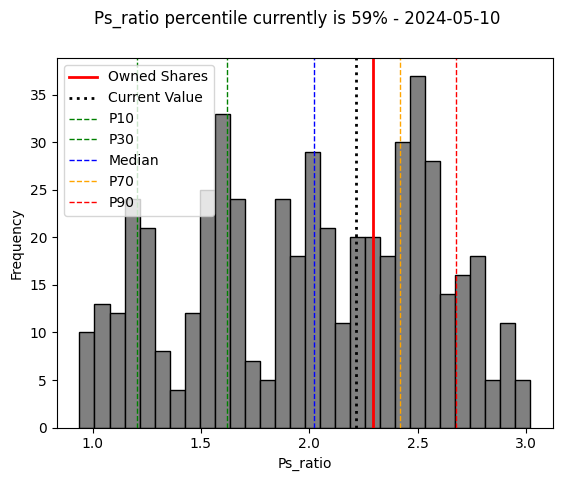

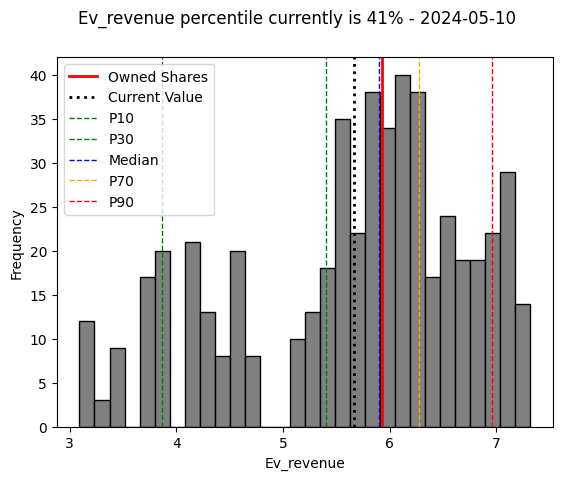

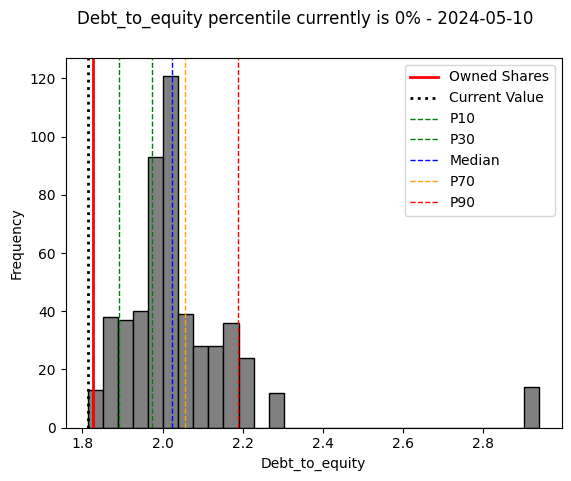

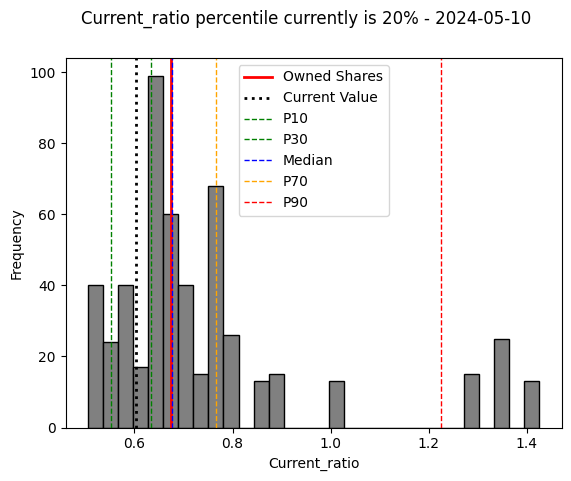

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.994709,-0.626553,0.147219,0.441575,0.433283,-0.539126,0.328100
roe,0.994709,1.000000,-0.655785,0.133468,0.430387,0.442575,-0.490913,0.317236
pe_ratio,-0.626553,-0.655785,1.000000,0.565727,0.368799,0.229026,0.069620,-0.284503
pb_ratio,0.147219,0.133468,0.565727,1.000000,0.851454,0.683874,-0.073566,0.141477
ps_ratio,0.441575,0.430387,0.368799,0.851454,1.000000,0.936017,-0.221131,0.170356
ev_revenue,0.433283,0.442575,0.229026,0.683874,0.936017,1.000000,-0.004711,0.125127
debt_to_equity,-0.539126,-0.490913,0.069620,-0.073566,-0.221131,-0.004711,1.000000,-0.070891
current_ratio,0.328100,0.317236,-0.284503,0.141477,0.170356,0.125127,-0.070891,1.000000


197 timestemos have been found!


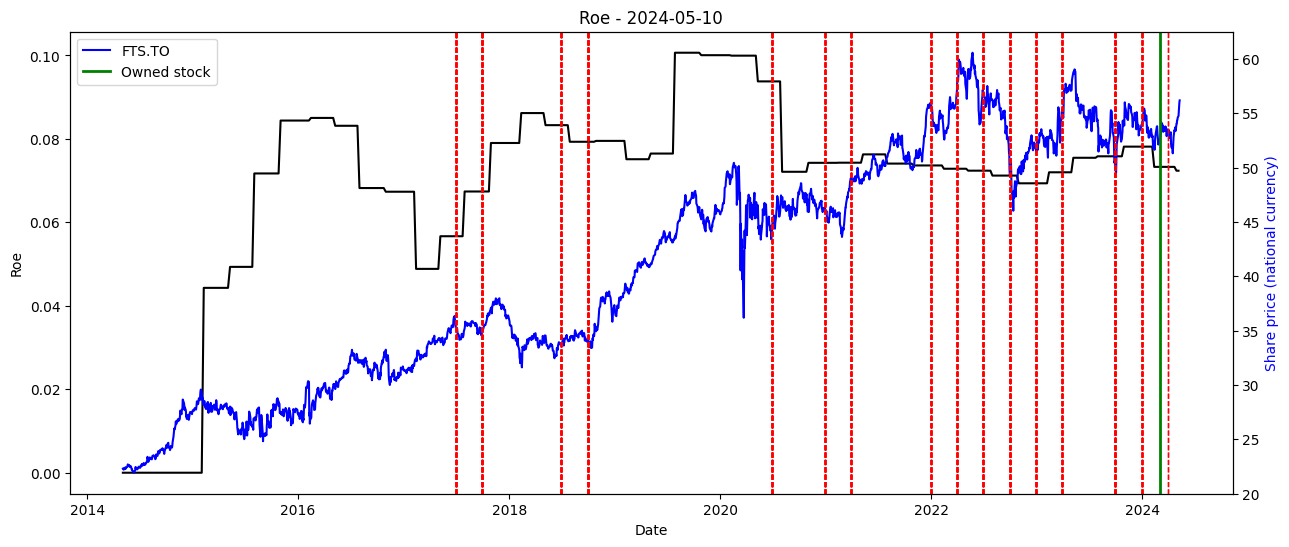

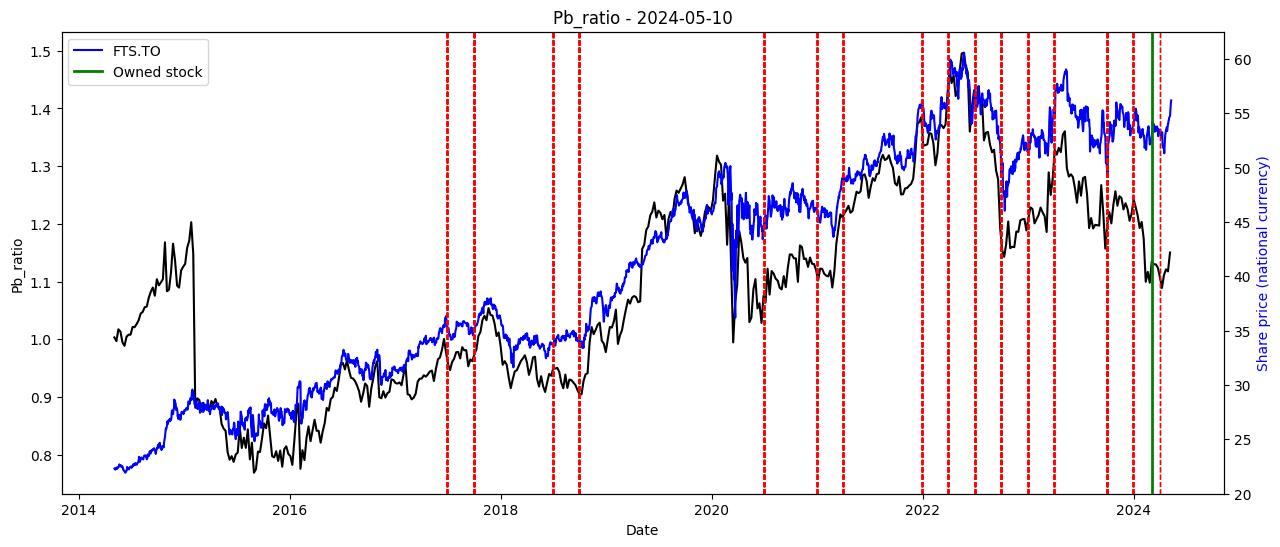

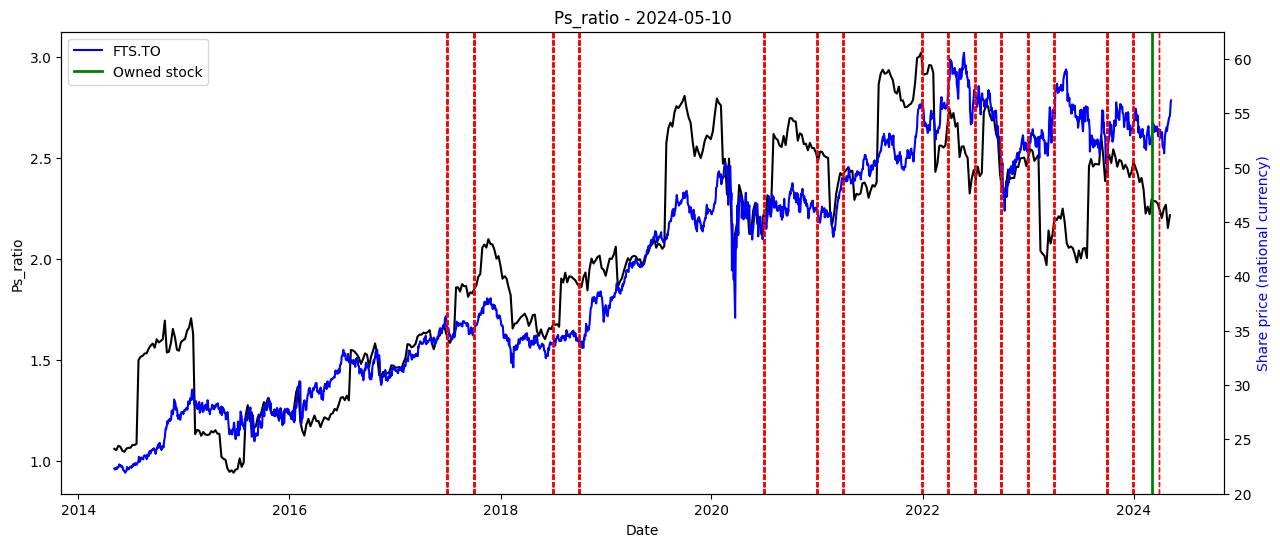

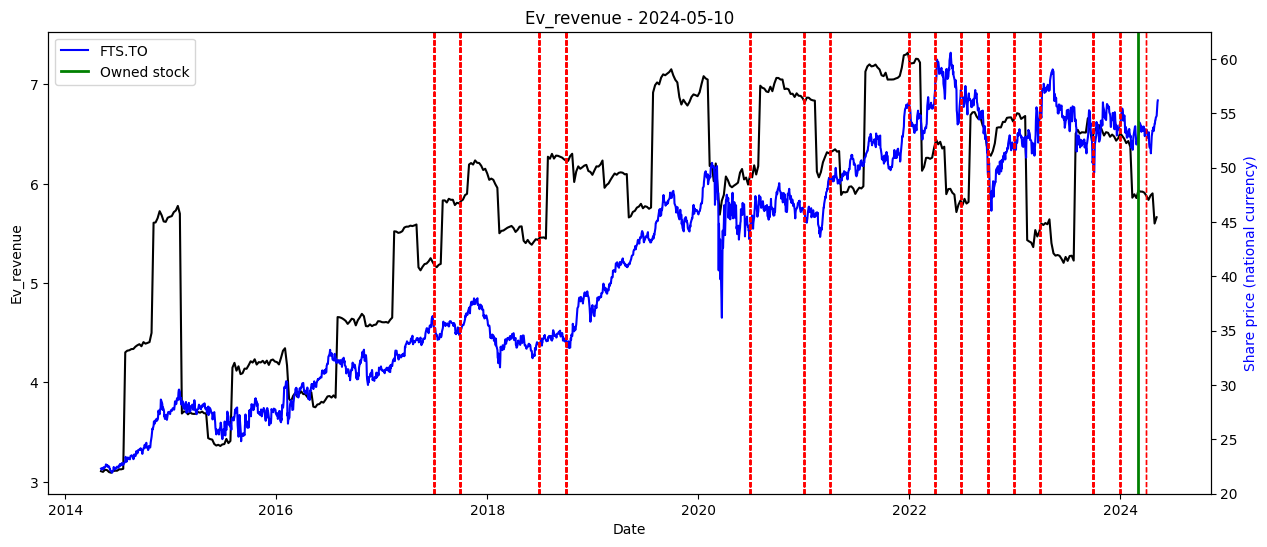

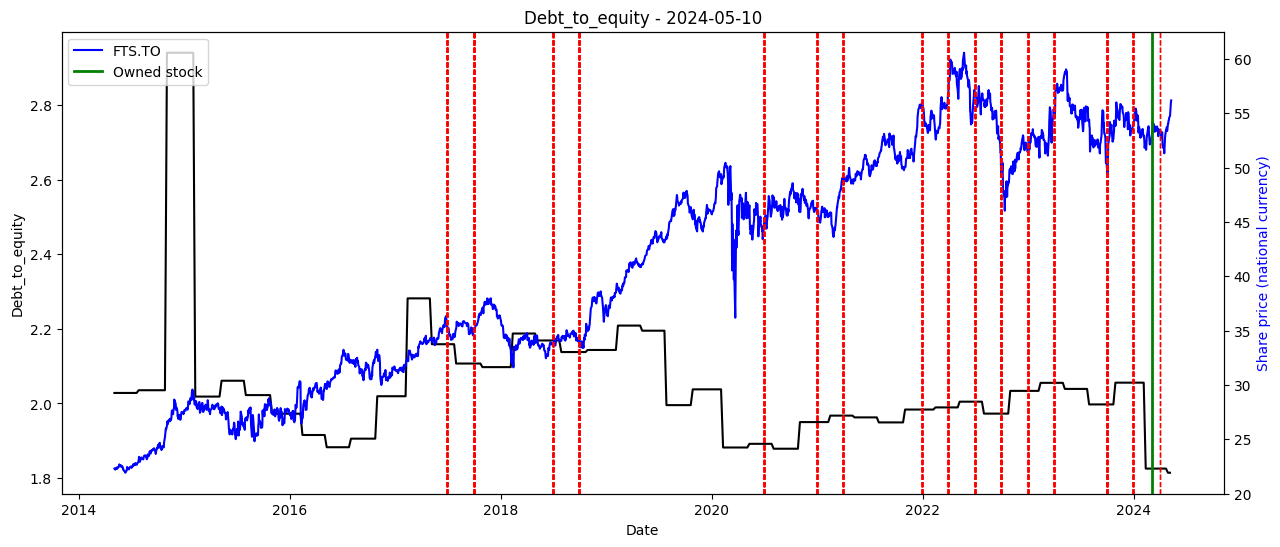

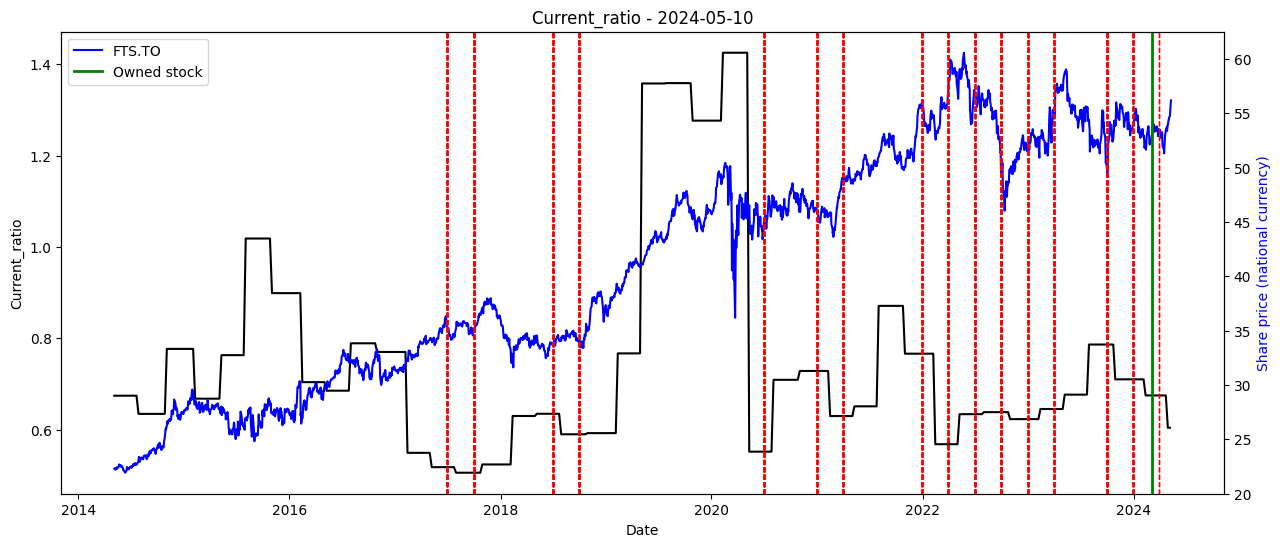

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )